# Семантическая Сегментация

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO

Библиотеки: [Python, Tensorflow]

### Подготовка данных

In [1]:
!mkdir -p coco-data

In [2]:
!cd coco-data && git clone https://github.com/cocodataset/cocoapi
!cd coco-data/cocoapi/PythonAPI && make

Клонирование в «cocoapi»…
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Получение объектов: 100% (975/975), 11.72 МиБ | 15.99 МиБ/с, готово.
Определение изменений: 100% (576/576), готово.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/home/alex/anaconda3/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/alex/GB-CV/coco-data/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/pycocotools
gcc -pthread -B /home/alex/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/alex/.local/l

In [3]:
!cd coco-data && wget http://images.cocodataset.org/zips/train2014.zip

--2021-10-16 00:08:44--  http://images.cocodataset.org/zips/train2014.zip
Распознаётся images.cocodataset.org (images.cocodataset.org)... 52.216.177.75
Подключение к images.cocodataset.org (images.cocodataset.org)|52.216.177.75|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 200 OK
Длина: 13510573713 (13G) [application/zip]
Сохранение в каталог: ««train2014.zip»».

train2014.zip       100%[===================>]  12,58G  17,6MB/s    за 18m 34s 

2021-10-16 00:27:18 (11,6 MB/s) - «train2014.zip» сохранён [13510573713/13510573713]



In [5]:
!cd coco-data && unzip -q train2014.zip

replace train2014/COCO_train2014_000000270070.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
!cd coco-data && rm train2014.zip

In [7]:
!cd coco-data && wget http://images.cocodataset.org/zips/val2014.zip

--2021-10-16 00:45:04--  http://images.cocodataset.org/zips/val2014.zip
Распознаётся images.cocodataset.org (images.cocodataset.org)... 52.216.88.171
Подключение к images.cocodataset.org (images.cocodataset.org)|52.216.88.171|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 200 OK
Длина: 6645013297 (6,2G) [application/zip]
Сохранение в каталог: ««val2014.zip»».

val2014.zip         100%[===================>]   6,19G  13,5MB/s    за 9m 25s  

2021-10-16 00:54:29 (11,2 MB/s) - «val2014.zip» сохранён [6645013297/6645013297]



In [8]:
!cd coco-data && unzip -q val2014.zip

In [9]:
!cd coco-data && rm val2014.zip

In [10]:
!cd coco-data && wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

--2021-10-16 01:04:23--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Распознаётся images.cocodataset.org (images.cocodataset.org)... 52.217.18.76
Подключение к images.cocodataset.org (images.cocodataset.org)|52.217.18.76|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 200 OK
Длина: 252872794 (241M) [application/zip]
Сохранение в каталог: ««annotations_trainval2014.zip»».

annotations_trainva 100%[===================>] 241,16M  9,65MB/s    за 25s     

2021-10-16 01:04:48 (9,58 MB/s) - «annotations_trainval2014.zip» сохранён [252872794/252872794]



In [11]:
!cd coco-data && unzip -q annotations_trainval2014.zip

In [12]:
!rm coco-data/annotations_trainval2014.zip

### Семантическая сегментация

In [33]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import random
import os
import skimage.io as io
import sys
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [16]:
COCO_ROOT = './coco-data'
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))

#### Пайплайн загрузки датасета

In [18]:
BATCH_SIZE = 16 
IMG_INP_SIZE = 32*5

In [19]:
class Dataset():
    
    """
    Универсальный класс предобработки изображений для задач сегментации
    """

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [29]:
class COCO_Dataset(Dataset):
    
    """
    Класс для сегментационного датасета COCO
    Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.
    """

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2014.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [30]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.26s)
creating index...
index created!
loading annotations into memory...
Done (t=9.37s)
creating index...
index created!


In [31]:
EPOCHS = 1

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=EPOCHS, inp_size=IMG_INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=IMG_INP_SIZE)

#### Визуализация изображений

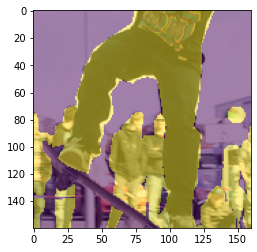

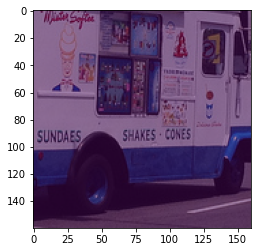

In [34]:
for idx in range(2):
    i = next(iter(val_ds))
    sample = i[0][idx].numpy()
    seg_map = plt.get_cmap('viridis')(i[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + seg_map*0.5)
    plt.show()

#### Подготовка модели (U-Net)

In [35]:
def build_model():
    x = tf.keras.layers.Input((IMG_INP_SIZE, IMG_INP_SIZE, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [37]:
model = build_model()

In [41]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer="adam", loss=loss)

#### Обучение и оценка результата

In [42]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           min_delta=1e-6,
                                                           patience=50,
                                                           verbose=1,
                                                           mode='auto',
                                                           baseline=None,
                                                           restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               patience=5,
                                                               verbose=1,
                                                               factor=0.5,
                                                               min_lr=0.00000001)

In [44]:
%%time

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    steps_per_epoch=len(COCO_dataset_train.img_list)//BATCH_SIZE, 
                    validation_data=val_ds, 
                    validation_steps=10,
                    callbacks=[learning_rate_reduction, early_stopping_callback])

2823/2823 [==============================] - 25662s 9s/step - loss: 0.4594 - val_loss: 0.4933
CPU times: user 1d 26min 34s, sys: 1h 7min 59s, total: 1d 1h 34min 34s
Wall time: 7h 7min 51s


In [46]:
INTERMEDIATE_STEP = 30

history = model.fit(train_ds,
                    epochs=EPOCHS * INTERMEDIATE_STEP,
                    steps_per_epoch=len(COCO_dataset_train.img_list)//BATCH_SIZE//INTERMEDIATE_STEP, 
                    validation_data=val_ds, 
                    validation_steps=10,
                    callbacks=[learning_rate_reduction, early_stopping_callback])

Epoch 1/30
94/94 [==============================] - 871s 9s/step - loss: 0.4463 - val_loss: 0.4752
Epoch 2/30
94/94 [==============================] - 872s 9s/step - loss: 0.4232 - val_loss: 0.5022
Epoch 3/30
94/94 [==============================] - 874s 9s/step - loss: 0.4121 - val_loss: 0.5065
Epoch 4/30
94/94 [==============================] - 876s 9s/step - loss: 0.4524 - val_loss: 0.4835
Epoch 5/30
94/94 [==============================] - 872s 9s/step - loss: 0.4196 - val_loss: 0.4801
Epoch 6/30
94/94 [==============================] - 871s 9s/step - loss: 0.4434 - val_loss: 0.4964

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/30
94/94 [==============================] - 871s 9s/step - loss: 0.4274 - val_loss: 0.4722
Epoch 8/30
94/94 [==============================] - 874s 9s/step - loss: 0.4162 - val_loss: 0.4989
Epoch 9/30
94/94 [==============================] - 875s 9s/step - loss: 0.4334 - val_loss: 0.4694
Epoch 10/30
94/94 [=========

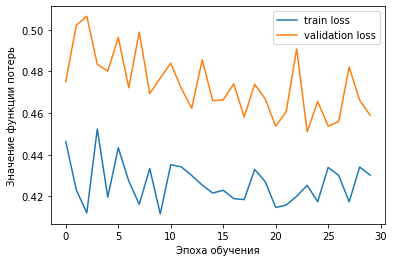

In [47]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()
plt.show()

In [65]:
test_batch = next(iter(val_ds))
prediction = model.predict(test_batch)

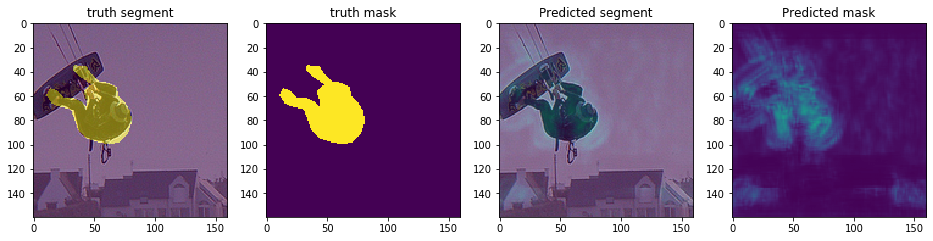

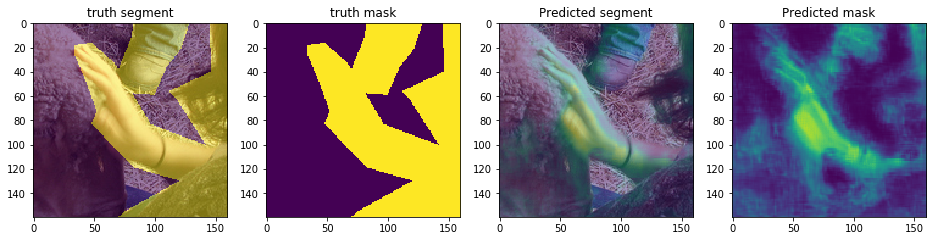

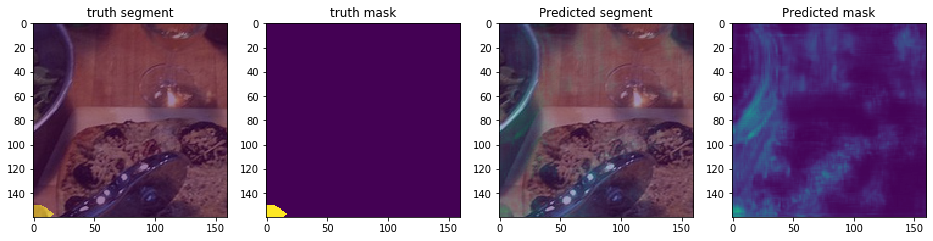

In [66]:
for idx in range(3):
    sample = test_batch[0][idx].numpy()
    
    fig = plt.figure(figsize=(16,6))
    
    plt.subplot(1,4,1)
    plt.title("truth segment")
    actual_seg_map = plt.get_cmap('viridis')(test_batch[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    plt.subplot(1,4,2)
    plt.title("truth mask")
    actual_seg_map = plt.get_cmap('viridis')(test_batch[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(actual_seg_map)
    plt.subplot(1,4,3)
    plt.title("Predicted segment")
    actual_seg_map = plt.get_cmap('viridis')(prediction[idx].reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    plt.subplot(1,4,4)
    plt.title("Predicted mask")
    actual_seg_map = plt.get_cmap('viridis')(prediction[idx].reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(actual_seg_map)
    
    plt.show()